In [ ]:
!pip install sentence-transformers
!pip install spacy-langdetect
!pip install symspellpy
!pip install stop_words

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from stop_words import get_stop_words
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from gensim.corpora.dictionary import Dictionary
import gensim
from nltk.stem.porter import PorterStemmer
from keras.models import Sequential
from keras.layers import Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load fake news dataset
filepath = r"drive/My Drive/Colab Notebooks/AdvancedML/Final_Project/data/fake_news.csv"
df = pd.read_csv(filepath, index_col=0)
df['titletext'] = df['title'] + " " + df['text']
print(df.shape)
df.head()

(6335, 4)


,title,text,label,titletext
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...


''

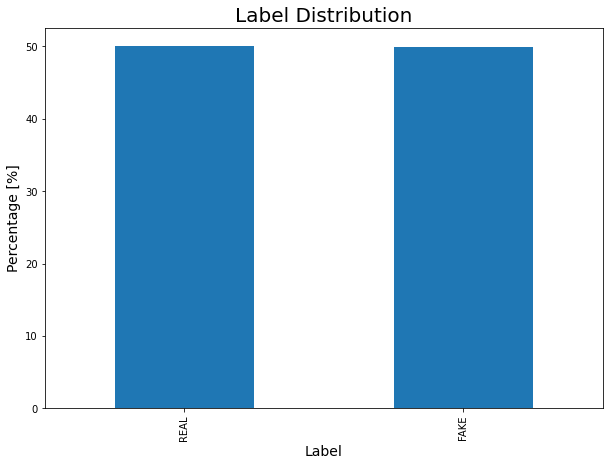

In [ ]:
# Labels Distribution 
plt.figure(figsize=(10,7))
(round(df["label"].value_counts() / df.shape[0] * 100, 2)).plot(kind="bar")
plt.title("Label Distribution", fontsize=20)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Percentage [%]", fontsize=14)
;

''

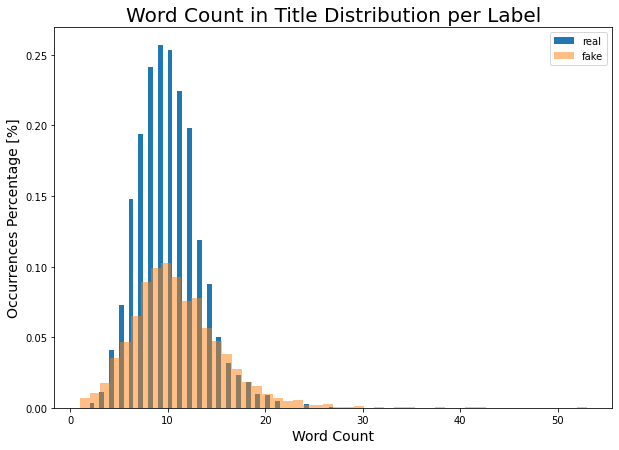

In [ ]:
# Distribution of the number of words in title per label
df["title_word_count"] = df["title"].apply(lambda x: len(x.split(" ")))
is_real_inds = df["label"] == "REAL"
plt.figure(figsize=(10,7))
plt.hist(df["title_word_count"].loc[is_real_inds], bins=50, label="real", density=True)
plt.hist(df["title_word_count"].loc[~is_real_inds], bins=50, label="fake", alpha=0.5, density=True)
plt.title("Word Count in Title Distribution per Label", fontsize=20)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Occurrences Percentage [%]", fontsize=14)
plt.legend()
;

We can see that in the fake news there tends to be more words in the title

''

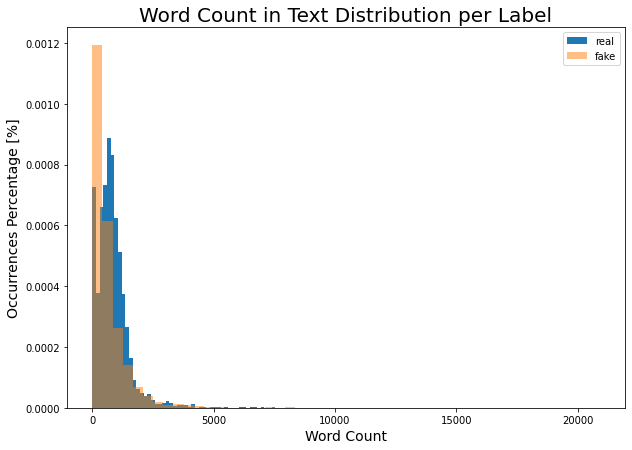

In [ ]:
# Distribution of the number of words in text per label
df["text_word_count"] = df["text"].apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,7))
plt.hist(df["text_word_count"].loc[is_real_inds], bins=50, label="real", density=True)
plt.hist(df["text_word_count"].loc[~is_real_inds], bins=50, label="fake", alpha=0.5, density=True)
plt.title("Word Count in Text Distribution per Label", fontsize=20)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Occurrences Percentage [%]", fontsize=14)
plt.legend()
plt.legend()
;

and in the text it's the opposite - there tends to be more words in the real news

### Preprocess

In [ ]:
def remove_punctuations(words):
  """
  returns the words without numbers and punctuations
  """
  words = [word for word in words if word.isalpha()]
  return words


def remove_stop_words(words):
  """
  returns the words in the sentence which are not stop words
  """
  stop_words = list(get_stop_words("en"))
  words = [word for word in words if word not in stop_words]
  return words


def keep_nouns(words):
  """
  returns words which are only nouns
  """
  words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2] == 'NN']
  return words


def stem_words(words):
  """
  returns the words' stems
  """
  p_stemmer = PorterStemmer()
  words = [p_stemmer.stem(word) for word in words]
  return words


def preprocess_sentence(sentence):
  """
  Performs the following preprocessing:
  1. Tokenizes sentence to separated words
  2. Remove punctuations
  3. Removes stop words
  3. 
  """
  words = word_tokenize(sentence)
  words = remove_punctuations(words)
  words = remove_stop_words(words)
  words = keep_nouns(words)
  words = stem_words(words)
  return words


def get_bert_vectors(articles):
  model = SentenceTransformer('bert-base-nli-max-tokens')
  vec = np.array(model.encode(articles, show_progress_bar=True))
  return vec


def get_topic_probability(corpus):
  topics_prediciton_arr = np.zeros((len(corpus), num_topics))
  topic_probabilities = [lda_model.get_document_topics(x) for x in corpus]
  for row_ind, topic in enumerate(topic_probabilities):
    for topic_ind, prob in topic:
      topics_prediciton_arr[row_ind, topic_ind] = prob
  return topics_prediciton_arr


def get_model():
  # define the keras model
  model = Sequential()
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
# split to train and test
labels = df["label"].map({"REAL": 0, "FAKE": 1}).values
df_x_train, df_x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [ ]:
# for BERT
sentences_x_train = df_x_train["text"].tolist()
sentences_x_test = df_x_test["text"].tolist()

# for LDA
words_x_train = df_x_train["text"].apply(preprocess_sentence)
words_x_test = df_x_test["text"].apply(preprocess_sentence)

In [ ]:
bert_vectors_train = get_bert_vectors(sentences_x_train)
bert_vectors_test = get_bert_vectors(sentences_x_test)

In [ ]:
# fit the keras model on the dataset
bert_model = get_model()
bert_model.fit(bert_vectors_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
127/127 [==============================] - 20s 5ms/step - loss: 0.6143 - accuracy: 0.6394 - val_loss: 0.4566 - val_accuracy: 0.7791
Epoch 2/5
127/127 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7785 - val_loss: 0.4831 - val_accuracy: 0.7613
Epoch 3/5
127/127 [==============================] - 0s 3ms/step - loss: 0.4084 - accuracy: 0.8069 - val_loss: 0.4588 - val_accuracy: 0.7761
Epoch 4/5
127/127 [==============================] - 0s 2ms/step - loss: 0.3686 - accuracy: 0.8260 - val_loss: 0.3797 - val_accuracy: 0.8264
Epoch 5/5
127/127 [==============================] - 0s 2ms/step - loss: 0.3342 - accuracy: 0.8567 - val_loss: 0.4209 - val_accuracy: 0.8087


In [ ]:
# evaluate the keras model
_, accuracy = bert_model.evaluate(bert_vectors_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

40/40 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8311
Accuracy: 83.11


# LDA

In [ ]:
num_topics = 20
dictionary = gensim.corpora.Dictionary(words_x_train)
corpus_train = [dictionary.doc2bow(text) for text in words_x_train]
corpus_test = [dictionary.doc2bow(text) for text in words_x_test]

# Train LDA model on the corpus
lda_model = gensim.models.ldamodel.LdaModel(corpus_train, num_topics=num_topics, id2word=dictionary)

In [ ]:
lda_model.print_topics()

[(0,
  '0.015*"polic" + 0.013*"offic" + 0.011*"peopl" + 0.008*"time" + 0.007*"year" + 0.007*"tax" + 0.007*"facebook" + 0.005*"s" + 0.005*"depart" + 0.005*"law"'),
 (1,
  '0.012*"state" + 0.009*"year" + 0.008*"school" + 0.007*"countri" + 0.007*"peopl" + 0.007*"new" + 0.006*"s" + 0.006*"time" + 0.006*"immigr" + 0.005*"paul"'),
 (2,
  '0.061*"trump" + 0.018*"clinton" + 0.014*"campaign" + 0.012*"s" + 0.011*"donald" + 0.011*"hillari" + 0.009*"republican" + 0.009*"cruz" + 0.008*"peopl" + 0.008*"presid"'),
 (3,
  '0.011*"bank" + 0.009*"year" + 0.009*"fed" + 0.009*"debt" + 0.008*"coal" + 0.008*"rate" + 0.007*"money" + 0.006*"market" + 0.006*"reserv" + 0.006*"dollar"'),
 (4,
  '0.037*"clinton" + 0.013*"email" + 0.013*"hillari" + 0.010*"s" + 0.010*"state" + 0.009*"campaign" + 0.007*"peopl" + 0.006*"new" + 0.006*"gold" + 0.006*"time"'),
 (5,
  '0.033*"clinton" + 0.013*"state" + 0.010*"fbi" + 0.010*"hillari" + 0.010*"elect" + 0.008*"investig" + 0.008*"presid" + 0.008*"campaign" + 0.008*"email" + 0

In [ ]:
# get topic probabilities for train set
topics_prediciton_train_arr = get_topic_probability(corpus_train)
topics_prediciton_test_arr = get_topic_probability(corpus_test)

In [ ]:
# concatenate BERT and LDA arrays
bert_lda_train = np.concatenate((bert_vectors_train, topics_prediciton_train_arr), axis=1)
bert_lda_test = np.concatenate((bert_vectors_test, topics_prediciton_test_arr), axis=1)

In [ ]:
# fit the keras model on the dataset
bert_lda_model = get_model()
bert_lda_model.fit(bert_lda_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
127/127 [==============================] - 1s 4ms/step - loss: 0.6422 - accuracy: 0.6263 - val_loss: 0.4485 - val_accuracy: 0.7801
Epoch 2/5
127/127 [==============================] - 0s 2ms/step - loss: 0.4373 - accuracy: 0.8018 - val_loss: 0.4013 - val_accuracy: 0.8097
Epoch 3/5
127/127 [==============================] - 0s 2ms/step - loss: 0.3676 - accuracy: 0.8393 - val_loss: 0.5352 - val_accuracy: 0.7318
Epoch 4/5
127/127 [==============================] - 0s 2ms/step - loss: 0.3749 - accuracy: 0.8320 - val_loss: 0.4230 - val_accuracy: 0.8156
Epoch 5/5
127/127 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8458 - val_loss: 0.3621 - val_accuracy: 0.8294


In [ ]:
# evaluate the keras model
_, accuracy = bert_lda_model.evaluate(bert_lda_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

40/40 [==============================] - 0s 1ms/step - loss: 0.3482 - accuracy: 0.8445
Accuracy: 84.45
